<a href="https://colab.research.google.com/github/NicknameSoHard/Open_course_ML/blob/master/ML_homework_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Вам предлагается реализовать два алгоритма – регрессор и классификатор, обучаемые стохастическим градиентным спуском (Stochastic Gradient Descent, SGD). [Веб-форма](https://docs.google.com/forms/d/1xlbc0CaUaNpVs-fhxkHUe61AtsvS_aDqQ0CLFxs6UDA) для ответов.

В [статье](https://habrahabr.ru/company/ods/blog/326418/) было описано, как таким образом обучать регрессор, т.е. минимизировать квадратичную функцию потерь. Реализуем этот алгоритм.

##  1. Линейная регрессия и SGD

In [0]:
!pip install tqdm

In [0]:
import numpy as np
import pandas as pd
#from tqdm import tqdm
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

Реализуйте класс `SGDRegressor`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$) и `n_iter` – число проходов по выборке (по умолчанию 10)
- также в конструкторе должны создаваться списки `mse_` и `weights_` для отслеживания значений среднеквадратичной ошибки и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit` и `predict`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса (см. [статью](https://habrahabr.ru/company/ods/blog/326418/)), а также записывает получившиеся на данной итерации значения среднеквадратичной ошибки (именно MSE, SE слишком большими будут) и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDRegressor`, т.е. `self`
- Метод `predict` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает вектор прогнозов модели, используя созданный методом `fit` вектор весов `w_`.

**Очень неудобно когда одно и то же рассказывают в двух местах частично по-разному**

In [0]:
class SGDRegressor(BaseEstimator):
    def __init__(self, eta = 0.001, n_iter = 10):
      self.eta = eta
      self.n_iter = n_iter
      self.mse_ = []
      self.weights_ = []

    def fit(self, X, y):
      X = np.hstack([np.ones([X.shape[0], 1]), X])
      w = np.zeros(X.shape[1])
        
      for n in range(self.n_iter):
        for i in range(X.shape[0]):
          w[0] += self.eta * (y[i] - w.dot(X[i, :]))
          for j in range(1, X.shape[1]):
            w[j] += self.eta * (y[i] - w.dot(X[i, :])) * X[i, j]
          self.weights_.append(w.copy())
          self.mse_.append(mean_squared_error(y, X.dot(w)))       
      self.w_ = self.weights_[self.mse_.index(min(self.mse_))]
        
      return self      

    def predict(self, X):
      X_expanded = np.hstack((np.ones((X.shape[0],1)),X))
      y_pred_list = []
      for x in X_expanded:
        y_pred_list.append( np.sum(self.w_ * x) )
      #print(y_prog, sep =' ')
      return y_pred_list


Проверим работу алгоритма на данных по росту и весу. Будем прогнозировать рост (в дюймах) по весу (в фунтах).

In [0]:
!wget "https://raw.githubusercontent.com/Yorko/mlcourse_open/master/data/weights_heights.csv" -P drive/Open_course_ML

In [72]:
data_demo = pd.read_csv('drive/Open_course_ML/weights_heights.csv')
np.array(data_demo['Weight'])

array([112.9925, 136.4873, 153.0269, ..., 118.2655, 132.2682, 124.874 ])

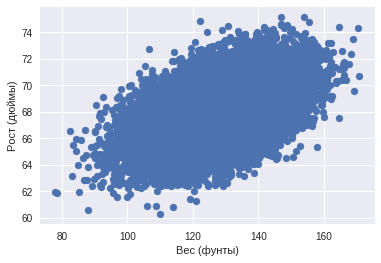

In [73]:
plt.scatter(data_demo['Weight'], data_demo['Height']);
plt.xlabel('Вес (фунты)')
plt.ylabel('Рост (дюймы)');

In [0]:
X, y = data_demo['Weight'].values, data_demo['Height'].values

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)

In [0]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([X_train.shape[0], 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([X_valid.shape[0], 1]))

Обучите созданный вами `SGDRegressor` на выборке `(X_train_scaled, y_train)`. Параметры оставьте по умолчанию.

In [0]:
sgdr = SGDRegressor().fit(X_train_scaled, y_train)

Изобразите на графике процесс обучения – как среднеквадратичная ошибка зависит от номера итерации стохастического градиентного спуска.

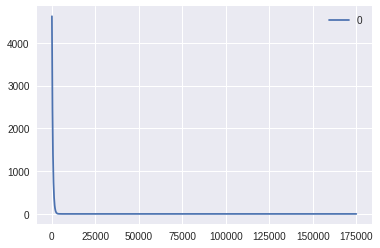

In [78]:
pd.DataFrame(data=sgdr.mse_, dtype=float).plot()

Выведите наименьшее значение среднеквадратичной ошибки и лучший вектор весов модели.

In [79]:
print('Минимальная среднеквадратическая ошибка:', min(sgdr.mse_))
print('Веса модели: w0 =', sgdr.w_[0],'w1 =', sgdr.w_[1] )

Минимальная среднеквадратическая ошибка: 2.7151352148331966
Веса модели: w0 = 67.98984926081923 w1 = 0.9444903071316347


Постройте график того, как менялись значения весов модели ($w_0$ и $w_1$) по мере обучения.

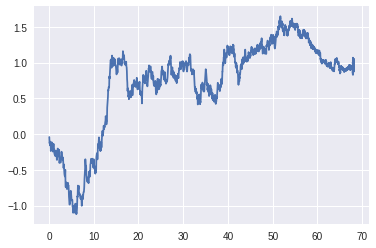

In [80]:
plt.plot([w[0] for w in sgdr.weights_], [w[1] for w in sgdr.weights_]);

Сделайте прогноз для отложенной выборки `(X_valid_scaled, y_valid)` и посмотрите на MSE.

In [81]:
mse_sgdr = mean_squared_error(sgdr.predict(X_valid_scaled), y_valid)
mse_sgdr

2.670867559718745

Теперь следайте то же самое, но с `LinearRegression` из `sklearn.linear_model`. Посчитайте MSE для отложенной выборки.

In [82]:
from sklearn.linear_model import LinearRegression 

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

mse_lr = mean_squared_error(lr.predict(X_valid_scaled), y_valid)
mse_lr

2.670830767667634

In [83]:
mse_sgdr-mse_lr

3.6792051111067536e-05

<font color='red'>Вопрос 1.</font> В каком знаке после разделителя отличаются MSE линейной регрессии и `SGDRegressor` для отложенной выборки?
 - 2
 - 3
 - 4
 - ** 5**

## 2. Логистическая регрессия и SGD
Теперь давайте разберемся, как при таком же стохастическом подходе обучать логистическую регрессию.

Задача классификации, $X$ – обучающая выборка размеров $\ell \times (d+1)$ (первый столбец – вектор из единиц), $y$ – вектор ответов, $y_i \in \{-1, 1\}$.
В [4 статье](https://habrahabr.ru/company/ods/blog/323890/) серии мы подробно разбирали, как логистическая регрессия с $L_2$-регуляризацией сводится к задаче минимизации:
$$ C\sum_{i=1}^\ell \log{(1 + e^{-y_iw^Tx_i})} + \frac{1}{2}\sum_{j=1}^d w_j^2 \rightarrow min_w$$

<font color='red'>Вопрос 2.</font> По какой формуле будут пересчитываться веса логистической регрессии при обучении стохастическим градиентным спуском?
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) +  \delta_{j\neq0} w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) +  \delta_{j\neq0}w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) -  \delta_{j\neq0}w_j )$
 - **$w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) -  \delta_{j\neq0}w_j)$<- Это оно**
 
Здесь 
- $i \in {0,\ldots, \ell-1}, j \in {0,\ldots, d}$
- C – коэффициент регуляризации
- $x_{ij} $ – элемент матрицы X в строке $i$ и столбце $j$ (нумерация с 0), 
- $x_i$ – $i$-ая строка матрицы $X$ (нумерация с 0), 
- $w_j^{(t)}$ – значение $j$-ого элемента вектора весов $w$ на шаге $t$ стохастического градиентного спуска
- $\eta$ – небольшая константа, шаг градиентного спуска
- $\delta_{j\neq0}$ – символ Кронекера, то есть 1, когда $j\neq0$ и $0$ – в противном случае

Реализуйте класс `SGDClassifier`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$), `n_iter` – число проходов по выборке (по умолчанию 10) и C – коэффициент регуляризации
- также в конструкторе должны создаваться списки `loss_` и `weights_` для отслеживания значений логистических потерь и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit`, `predict` и `predict_proba`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`, рассматриваем только случай бинарной классификации, и значения в векторе `y` могут быть -1 и 1), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса по выведенной вами формуле, а также записывает получившиеся на данной итерации значения log_loss и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDClassifier`, т.е. `self`
- Метод `predict_proba` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает матрицу прогнозов модели (такую же, какую возвращают методы `predict_proba` моделей `sklearn`), используя созданный методом `fit` вектор весов `w_`
- Метод `predict` вызывает метод  `predict_proba` и возвращает вектор ответов: -1, если предсказанная вероятность класса 1 меньше 0.5 и 1 – в противном случае
- И еще **важный момент**: во избежание вычислительных проблем из-за слишком больших или малых значений под экспонентной (overflow & underflow) используйте написанную функцию `sigma`

In [0]:
def sigma(z):
    z = z.flatten()
    z[z > 100] = 100
    z[z < -100] = -100
    return 1. / (1 + np.exp(-z))

In [0]:
class SGDClassifier(BaseEstimator):
  def __init__(self, C, eta = 0.001, n_iter = 10):
    self.eta = eta
    self.n_iter = n_iter
    self.C = C
    self.loss_ = []
    self.weights_ = []
    
  def fit(self, X, y):
    X = np.hstack([np.ones([X.shape[0], 1]), X])
    w = np.ones(X.shape[1])
        
    for it in range(self.n_iter):
      for i in range(X.shape[0]):
        w[0] += self.eta * y[i] * sigma(- y[i] * w.dot(X[i, :]))
        for j in range(1, X.shape[1]):
          w[j] += self.eta *( self.C * y[i] * X[i, j] * 
                                       sigma(-y[i] * w.dot(X[i, :]))
                                    -  w[j])
                
        self.loss_.append(log_loss(y, sigma(X.dot(w))))
        self.weights_.append(w)
    
    self.w_ = self.weights_[np.argmin(self.loss_)]
    return self
  
  def predict(self, X):
    result = []
    for x in predict_proba(X):
      if x > 0.5:
        result.append(-1)
      else:
        result.append(1)
    return result
  
  def predict_proba(self, X):
    X_new = np.insert(X, 0, 1, axis=1)  
    p_vec = sigma(X_new.dot(self.w_)).reshape([X_new.shape[0], 1])    
    return np.hstack([1 - p_vec, p_vec])
                  

Проверим `SGDClassifier` на данных UCI по раку молочной железы.

In [0]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
# поменяем метки в y с 0 на -1
X, y = cancer.data, [-1 if i == 0 else 1 for i in cancer.target]

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size = 0.3,
                                                     random_state = 17)

In [0]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

Обучите на масштибированной выборке `SGDClassifier` с параметрами `C`=1, `eta`=$10^{-3}$ и `n_iter`=3.

In [0]:
sgdc = SGDClassifier(C=1, eta=0.001, n_iter=3).fit(X_train_scaled, y_train)

Постройте график изменения log_loss.

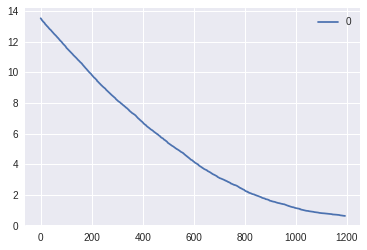

In [90]:
pd.DataFrame(data=sgdc.loss_, dtype=float).plot()

Теперь обучите `SGDClassifier` с параметром `C`=1000, число проходов по выборке увеличьте до 10.

In [0]:
sgdc_second = SGDClassifier(C=1000, eta=0.001, n_iter=10).fit(X_train_scaled, y_train)

Посмотрите на веса модели, при которых ошибка на обучении была минимальна.

In [92]:
sgdc_second.w_

array([ 0.99407341, -1.12870677, -0.79097561, -0.0967224 , -0.07390861,
       -0.49424025,  1.00318669, -1.35864914, -1.56253297,  0.14393583,
        0.59748894, -1.80614499, -0.06356839, -0.33032558, -1.00054563,
        0.25777574,  1.56516357, -0.51799109,  0.16821783,  0.02365163,
        0.68150705, -1.02890177, -0.61393469, -0.8654416 , -1.09152451,
       -1.91813   , -0.4449124 , -1.56868055, -0.88361326, -0.77832902,
       -0.55584325])

<font color='red'>Вопрос 3.</font> Какой признак сильнее остальных влияет на вероятность того, что опухоль доброкачественна, согласно обученной модели `SGDClassifier`? (будьте внимательны – проверьте длину вектора весов, полученного после обучения, сравните с числом признаков в исходной задаче)
 - worst compactness
 - **worst smoothness**
 - worst concavity
 - concave points error
 - concavity error
 - compactness error
 - worst fractal dimension

In [93]:
best_w = sgdc_second.weights_[np.argmin(sgdc_second.loss_)]
cancer.feature_names[np.argmin(best_w)-1]

'worst smoothness'

Посчитайте log_loss и ROC AUC на отложенной выборке, проделайте все то же с `sklearn.linear_model.LogisticRegression` (параметры по умолчанию, только random_state=17) и сравните результаты.

In [94]:
sgdc_second_pred = sgdc_second.predict_proba(X_valid_scaled)[:, 1]
log_loss(y_valid, sgdc_second_pred), roc_auc_score(y_valid, sgdc_second_pred)

(0.14271908653850107, 0.9879284649776454)

In [95]:
from sklearn.linear_model import LogisticRegression

ls = LogisticRegression(random_state=17).fit(X_train_scaled, y_train)
ls_pred = ls.predict_proba(X_valid_scaled)[:, 1]
log_loss(y_valid, ls_pred), roc_auc_score(y_valid, ls_pred)

(0.10569213477936722, 0.9892697466467957)

## 3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

Теперь посмотрим на логистическую регрессию и ее же версию, но обучаемую стохастическим градиентным спуском, в задаче классификации отзывов IMDB. С этой задачей мы знакомы по 4 и 8 темам курса. Данные можно скачать [отсюда](https://drive.google.com/open?id=1xq4l5c0JrcxJdyBwJWvy0u9Ad_pvkJ1l).

Импортируем файлы, и обучим на имеющихся данных `CountVectorizer`

In [0]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier

In [0]:
reviews_train = load_files("/Users/y.kashnitsky/Documents/Machine_learning/datasets/imdb_reviews/train")
text_train, y_train = reviews_train.data, reviews_train.target

In [0]:
reviews_test = load_files("/Users/y.kashnitsky/Documents/Machine_learning/datasets/imdb_reviews/test")
text_test, y_test = reviews_test.data, reviews_test.target

Обучим на имеющихся данных `CountVectorizer`, считая биграммы, то есть перейдем к разреженному представлению данных, где каждому уникальному слову и паре подряд идущих слов в обучающей выборке соответсвует признак. Всего таких признаков получается более 1.5 млн.

In [0]:
%%time
cv = CountVectorizer(ngram_range=(1, 2))
X_train = cv.fit_transform(text_train)
X_test = cv.transform(text_test)

X_train.shape, X_test.shape

Обучите на выборке `(X_train, y_train)` логистическую регрессию с параметрами по умолчанию (только укажите `random_state`=17) и посчитайте ROC AUC на тестовой выборке. Замерьте время обучения модели. Данные можно не масштабировать, так как признаки – по сути, счетчики, и они уже все измеряются примерно в одном диапазоне.

In [0]:
%%time
lr = LogisticRegression(random_state=17)
lr.fit(X_train, y_train)

roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])

Теперь перейдем к онлайн-алгоритму. Мы написали свой `SGDClassifier` и принцип его работы поняли, надо еще немного постараться, чтобы сделать его эффективным, например, сделать поддержку разреженных данных. Но мы теперь перейдем к `sklearn`-реализации SGD-алгоритма. Прочитайте документацию [SGDClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), сделайте выводы, чем `SGDClassifier` из `Sklearn` более продвинут, чем наша реализация SGD-классификатора. 

<font color='red'>Вопрос 4.</font> Чем `sklearn`-реализация стохастического классификатора более продвинута, чем `SGDClassifier`, который мы реализовали? Отметьте все подходящие варианты.
 - **Изменяемый шаг градиентного спуска**
 - **Реализован линейный SVM**
 - Реализована ранняя остановка во избежание переобучения
 - **Есть распараллеливание по процессорам**
 - Можно обучать LASSO
 - Поддерживается онлайн-обучение деревьев решений
 - **Поддерживается mini-batch подход (обновление весов по нескольким объектом сразу, а не по одному)**


Проведите 100 итераций SGD-логрегрессии (опять `random_state`=17) на той же выборке. Опять замерьте время обучения модели и обратите внимание, насколько оно меньше, чем время обучения логистической регрессии.

In [0]:
%%time
sgd = SGDClassifier(loss='log', n_iter=100, random_state=17)
sgd.fit(X_train, y_train)

y_pred = sgd.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

<font color='red'>Вопрос 5.</font> В каком знаке после разделителя отличаются ROC AUC на тестовой выборке логистической регрессии и SGD-классификатора `Sklearn` с логистической функцией потерь?
 - 2
 - ** 3**
 - 4
 - 5